In [1]:
%matplotlib inline
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import nan
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.wait import WebDriverWait

In [2]:
## create a pandas dataframe to store the scraped data
df = pd.DataFrame(
                  columns=['hotel', 'rating', 'distance', 'score', 'recommendation_ratio', 'review_number', 'lowest_price'])

## launch Firefox driver, please change directory to the location of your Geckodriver exe file and save that as my_path
#Use Chromedriver for launching chrome
#Use Edgedriver for launching edge

# headless mode 
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--disable-gpu')
chrome_options.add_argument('--window-size=1920x1080')  # indispensable


my_path = r"chromedriver.exe" # choose your own path
browser = webdriver.Chrome(chrome_options=chrome_options, executable_path=my_path) #webdriver.Chrome for chromedriver
browser.maximize_window()

C:\Users\Saplace\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: use options instead of chrome_options


In [3]:
def get_elements(xpath, attr = 'text', pattern = ''):
    elements = browser.find_elements_by_xpath(xpath) # find the elements according to conditions stated in xpath
    if (attr == 'text'):
        res = list(map(lambda x: x.text, elements))
    else:
        res = list(map(lambda x: x.get_attribute(attr),elements))
    
    return res

In [4]:
columns=['hotel', 'rating', 'distance', 'score', 'recommendation_ratio', 'review_number', 'lowest_price'];
df = pd.DataFrame(columns=columns)

place = '旺角'; # choose a place in HK
url = r"http://hotels.ctrip.com/hotel/hong%20kong58/k1"+place;
try:
    browser.get(url)

    star3 = browser.find_element_by_id("star-3")
    star4 = browser.find_element_by_id("star-4")
    star5 = browser.find_element_by_id("star-5")
    # choose hotels that >= 3 stars
    ActionChains(browser).click(star3).perform()
    ActionChains(browser).click(star4).perform()
    ActionChains(browser).click(star5).perform()

    time.sleep(4) # better way: WebDriverWait

    from selenium.webdriver.support.wait import WebDriverWait
    tst = WebDriverWait(browser, 5).until(
        lambda x: x.find_element_by_link_text("下一页"))

    clo =browser.find_element_by_id('appd_wrap_close')
    ActionChains(browser).move_to_element(clo).click(clo).perform()


    page = 0
    while (tst.get_attribute('class') != 'c_down_nocurrent'): # utill the last page
        page += 1
        # hotel brand
        hotel_xpath = "//h2[@class='hotel_name']/a"
        hotel = get_elements(hotel_xpath,'title')

        hnum = len(hotel) # hotel numbers in current page

        # hotel rating
        rating_xpath = "//span[@class='hotel_ico']/span[starts-with(@class,'hotel_diamond')]"
        rating = get_elements(rating_xpath,'class')
        rating = [rating[i][-1:] for i in range(hnum)]


        # distance 
        distance_xpath = "//p[@class='hotel_item_htladdress']/span[@class='dest_distance']"
        distance = get_elements(distance_xpath)
        distance_pattern = re.compile(r"\D+(\d+.\d+)\D+");
        distance = list(map(lambda x: distance_pattern.match(x).group(1), distance))

        # score
        score_xpath = "//div[@class='hotelitem_judge_box']/a | //div[@class='hotelitem_judge_box']/span[@class='no_grade']"
        score = get_elements(score_xpath,'title')
        score_pattern = re.compile(r"\D+(\d+.\d+)\D+?");
        score = list(map(lambda x: '/' if x=='暂无评分' or x=='' else score_pattern.match(x).group(1), score))

        # recommendation
        ratio_xpath = "//div[@class='hotelitem_judge_box']/a/span[@class='total_judgement_score']/span | //div[@class='hotelitem_judge_box']/span[@class='no_grade']"
        ratio = get_elements(ratio_xpath)

        # review
        review_xpath = "//div[@class='hotelitem_judge_box']/a/span[@class='hotel_judgement']/span | //div[@class='hotelitem_judge_box']/span[@class='no_grade'] "
        review = get_elements(review_xpath)

        # lowset price
        lowest_price_xpath = "//span[@class='J_price_lowList']"
        price = get_elements(lowest_price_xpath)

        rows = np.array([hotel, rating, distance, score, ratio, review, price]).T
        dfrows = pd.DataFrame(rows,columns=columns)
        df = df.append(dfrows,ignore_index=True)

        ActionChains(browser).click(tst).perform() # next page
        tst = WebDriverWait(browser, 10).until(
            lambda x: x.find_element_by_link_text("下一页"))

        print(tst.get_attribute('class'), page)
except Exception as e:
    print(e.__doc__)
    print(e.message)
finally:
    browser.quit()

## create a csv file in our working directory with our scraped data
df.to_csv(place+"_hotel.csv", index=False,encoding='utf_8_sig')
print('Scraping is done!')

c_down 1
c_down 2
c_down 3
c_down 4
c_down 5
c_down 6
c_down 7
c_down_nocurrent 8
Scraping is done!


In [5]:
df.score = pd.to_numeric(df.score, errors='coerce')
df.rating = pd.to_numeric(df.rating, errors='coerce')
#df.recommendation_ratio = pd.to_numeric(df.recommendation_ratio,errors='coerce')
df['distance']=pd.to_numeric(df['distance'], errors='coerce')
df.review_number = pd.to_numeric(df.review_number, errors='coerce')
df.lowest_price = pd.to_numeric(df.lowest_price,errors='coerce')
df=df.sort_values(by='distance')

In [6]:
df

,hotel,rating,distance,score,recommendation_ratio,review_number,lowest_price
0,香港旺角M1酒店(M1 Hotel Mong Kok),3,0.15,4.3,94%,760,1102
25,香港旺角M1酒店(M1 Hotel Mong Kok),3,0.15,4.3,94%,760,1102
1,香港康得思酒店(Cordis Hong Kong),5,0.20,4.7,99%,9063,1723
26,香港康得思酒店(Cordis Hong Kong),5,0.20,4.7,99%,9063,1723
27,香港旺角新天地酒店(Mong Kok Sunny Day Hotel),3,0.21,4.2,95%,715,934
2,香港旺角新天地酒店(Mong Kok Sunny Day Hotel),3,0.21,4.2,95%,715,934
28,香港逸豪酒店(H1 Hotel),3,0.25,4.3,93%,2766,2003
3,香港逸豪酒店(H1 Hotel),3,0.25,4.3,93%,2766,2003
29,香港碧荟酒店(The Beacon),4,0.26,4.7,98%,536,1048
4,香港碧荟酒店(The Beacon),4,0.26,4.7,98%,536,1048


In [7]:
def piepic():
    plt.figure(num='Rpie',dpi=100) 
    labels = ['3 stars', '4 stars', '5 stars']
    sizes = [df.rating[df.rating==k].count() for k in [3,4,5] ]
    colors = ['gold', 'lightcoral', 'lightskyblue']
    explode = (0.01, 0.01, 0.01)  # explode 1st slice
    def atxt(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}%\n({:d})".format(pct, absolute)
    # Plot
    plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct=lambda pct: atxt(pct, sizes),
             shadow=True, startangle=140)
    plt.legend(labels,
              title="hotel rating")
    plt.axis('equal')
    plt.savefig('Rpie.jpg')
    plt.show()
    plt.close()

In [8]:
def DvPpic(): # distance vs price
    plt.figure(num='DvP',dpi=100) 
    plt.plot(df.distance[df.rating==3],df.lowest_price[df.rating==3],'x-',label='3 stars')
    plt.plot(df.distance[df.rating==4],df.lowest_price[df.rating==4],'*-',label='4 stars')
    plt.plot(df.distance[df.rating==5],df.lowest_price[df.rating==5],'rD-',label='5 stars')
    plt.legend()
    plt.xlabel('Distance (km)')
    plt.ylabel('Price (Yuan)')
    plt.grid()
    plt.title('Distance vs. Price')
    plt.savefig('DvP.jpg')
    plt.show()
    plt.close()

In [9]:
def Pdensity():
    plt.figure(num='Pdensity',dpi=100) 
    df.lowest_price[df.rating==3].plot(kind='density',label='3 stars')
    df.lowest_price[df.rating==4].plot(kind='density',label='4 stars')
    df.lowest_price[df.rating==5].plot(kind='density',label='5 stars')
    plt.grid()
    plt.legend()
    plt.xlabel('Price (Yuan)')
    plt.title('Distribution of Price')
    plt.savefig('Pdensity.jpg')
    plt.show()

In [10]:
def Sbox():
    plt.figure(num='Sbox',dpi=200) 
    data = pd.concat([df.score[df.rating==3].rename('3 stars'),
                      df.score[df.rating==4].rename('4 stars'),
                      df.score[df.rating==5].rename('5 stars')],
                      axis=1)
    data.plot.box()
    plt.minorticks_on()
    plt.ylabel('score')
   # plt.grid(b=True, which='minor', color='r', linestyle='--')
    plt.title('Boxplot of Scores')
    plt.savefig('Sbox.jpg')
    #data.plot.box()
    

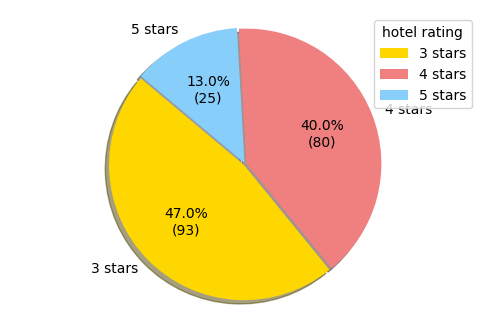

In [11]:
piepic()

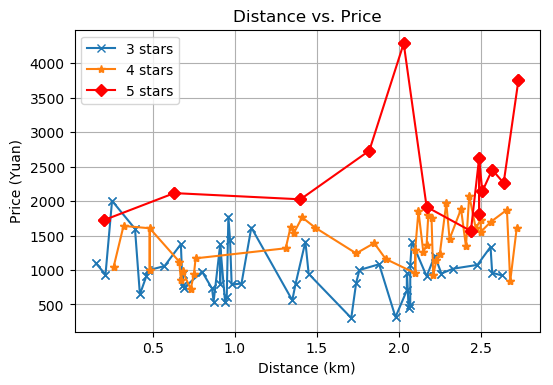

In [12]:
DvPpic()

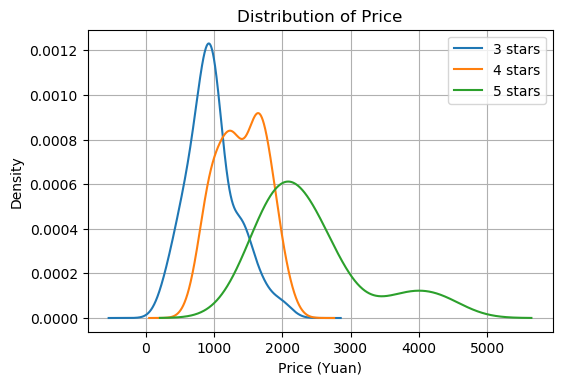

In [13]:
Pdensity()

<Figure size 1200x800 with 0 Axes>

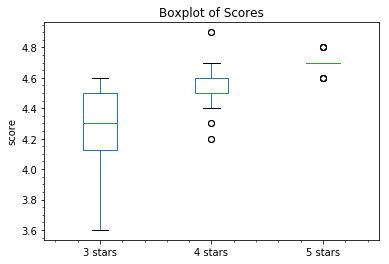

In [14]:
Sbox()